In [1]:
# keras相关包
from tensorflow.keras.applications import ResNet50
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array
from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import img_to_array
from keras.preprocessing.image import load_img

import random
# sklearn相关包
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelBinarizer
from sklearn.feature_extraction.image import extract_patches_2d

import numpy as np
import cv2
import os
from imutils import paths
import progressbar

# 作图
import matplotlib.pyplot as plt
%matplotlib inline

#Basic Tool
import pandas as pd
import sys
import io

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


### 加载cifar-10数据集

In [3]:
#设置随机种子
np.random.seed(161)

from keras.datasets import cifar10

In [4]:
#读取数据集
(x_train, y_train), (x_test, y_test) = cifar10.load_data()

#归一化
x_train = x_train / 255.0
x_test = x_test / 255.0

170508288/170498071 [==============================] - 3s 0us/step


In [5]:
from sklearn.model_selection import train_test_split
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size = 0.20, random_state = 31)

### 数据预处理

In [7]:
def imbalanceData(__format,X_train,y_train):
   """
   __format：The imbalance want to input
   X_train:Train Set
   y_train:Test Set
   """
   train_classes, train_class_counts=np.unique(y_train, return_counts=True)
   nb_train_classes = len(train_classes)
   class_indices = [np.where(y_train == i)[0] for i in range(nb_train_classes)]
   imbal_class_indices = [class_idx[:class_count] for class_idx, class_count in zip(class_indices, __format)]
   imbal_class_indices = np.hstack(imbal_class_indices)
   y = y_train[imbal_class_indices]
   X = x_train[imbal_class_indices]  
   return X,y

In [8]:
imbal_class_counts=[250,750,1250,1750,2250,2750,3250,3750,4250,5000]
imbal_class_counts=[int(i * 4/5) for i in imbal_class_counts]
x_train,y_train=imbalanceData(imbal_class_counts,x_train,y_train)

In [9]:
# Y 热编码
y_train_oh = to_categorical(y_train)
y_val_oh = to_categorical(y_val)
y_test_oh = to_categorical(y_test)

### ResNet50

In [10]:
# 加载不包含top层的ResNet50作为baseModel
baseModel = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32, 3)))

94781440/94765736 [==============================] - 1s 0us/step


In [11]:
def headmodel(baseModel):
    # 在baseModel基础上添加新的层
    headModel = baseModel.output
    
    # 新的 top 层
    headModel = Flatten()(headModel)
    headModel = Dense(10, activation="softmax")(headModel)
    return headModel

In [12]:
headModel = headmodel(baseModel)
model = Model(inputs=baseModel.input, outputs=headModel)

In [13]:
# 保存模型快照的回调函数
modelname = "cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5"

#monitor参数为val loss时，mode选参为min；save_best_only：当设置为True时，将只保存在验证集上性能最好的模型
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

# 冻结住baseModel所有层的参数不学习
for layer in baseModel.layers:
    layer.trainable = False

# 编译
# 学习率经过调参为0.01；将优化器设置为SGD(lr=learning rate, decay=learning rate/nb_ephoch, momentum=0.9, nesterov=True) st.学习速率随着训练轮次进行变化
sgd = SGD(lr=0.01, decay=0.01/20, momentum=0.9, nesterov=True) 
model.compile(loss="categorical_crossentropy", optimizer=sgd, metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [14]:
H = model.fit(x_train, y_train_oh, batch_size=32,
                        validation_data=(x_val, y_val_oh),
                        callbacks=[checkpoint],
                        epochs=20)


Epoch 1/20
632/632 [==============================] - ETA: 0s - loss: 29.2257 - accuracy: 0.1864

/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


632/632 [==============================] - 59s 44ms/step - loss: 29.2257 - accuracy: 0.1864 - val_loss: 10.8575 - val_accuracy: 0.2257
Epoch 2/20
632/632 [==============================] - 28s 44ms/step - loss: 12.1959 - accuracy: 0.2588 - val_loss: 21.2719 - val_accuracy: 0.1617
Epoch 3/20
632/632 [==============================] - 25s 40ms/step - loss: 7.4299 - accuracy: 0.3047 - val_loss: 11.3689 - val_accuracy: 0.1521
Epoch 4/20
632/632 [==============================] - 25s 40ms/step - loss: 5.0196 - accuracy: 0.3325 - val_loss: 5.5224 - val_accuracy: 0.2137
Epoch 5/20
632/632 [==============================] - 25s 40ms/step - loss: 3.8089 - accuracy: 0.3525 - val_loss: 7.7123 - val_accuracy: 0.1439
Epoch 6/20
632/632 [==============================] - 25s 40ms/step - loss: 3.0182 - accuracy: 0.3711 - val_loss: 4.3283 - val_accuracy: 0.2258
Epoch 7/20
632/632 [==============================] - 25s 40ms/step - loss: 2.5860 - accuracy: 0.3834 - val_loss: 3.2462 - val_accuracy: 0.279

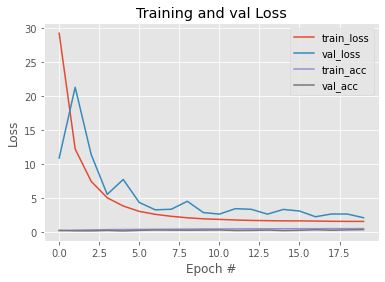

In [15]:
# 绘制loss和accuracy曲线
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 20), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 20), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 20), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 20), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.title("Training and val Loss")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend()
plt.show()

### 依据F1-score更新训练集

In [16]:
# Classified evaluation report
preds = model.predict(x_val, batch_size=32)
print(classification_report(y_val_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

              precision    recall  f1-score   support

           0     0.8000    0.0040    0.0079      1007
           1     0.3421    0.5945    0.4342      1011
           2     0.2857    0.3884    0.3292       999
           3     0.2497    0.4205    0.3133      1006
           4     0.7500    0.0029    0.0058      1039
           5     0.7963    0.0857    0.1547      1004
           6     0.6318    0.1846    0.2857      1013
           7     0.3415    0.6781    0.4542       991
           8     0.3118    0.8117    0.4505       940
           9     0.6501    0.2384    0.3489       990

    accuracy                         0.3363     10000
   macro avg     0.5159    0.3409    0.2784     10000
weighted avg     0.5182    0.3363    0.2761     10000



In [36]:
final_report = classification_report(y_val_oh.argmax(axis=1),preds.argmax(axis=1), digits=4)
report_pd = pd.read_csv(io.StringIO(final_report), delim_whitespace=True, error_bad_lines=False)

b'Skipping line 15: expected 5 fields, saw 6\nSkipping line 16: expected 5 fields, saw 6\n'


In [37]:
report_re = report_pd[:10]
report_re = report_re.reset_index()
report_re = report_re[["index", "f1-score"]]
report_re.columns=['class_name','f1_score']
#1-F1 score used for uodating the sample size 
report_re['1-f1_score'] = 1-report_re['f1_score']
ds_sum = report_re['1-f1_score'].sum() 
report_re["class_weight"] = report_re["1-f1_score"]/ds_sum
report_re["re_class_counts"] = (report_re["1-f1_score"]/ds_sum)*len(x_train)
report_re["row_distribution"] = pd.DataFrame(imbal_class_counts)
report_re['tt'] = report_re['re_class_counts'] - report_re['row_distribution']
report_re.loc[report_re["tt"]<0,"tt"] = report_re["re_class_counts"]
report_re002 = report_re[["class_name","class_weight","re_class_counts","row_distribution","tt"]]
report_re002["tt"] = round(report_re002["tt"])
report_re002.columns=['class_name',"class_weight","re_class_counts","row_distribution","update_num"]

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [38]:
def choosingImages(x_train,y_train):
  c_X_train=[]
  for i in range(10):
    # print(i)
    class_indices_=[np.where(y_train == i)[0]]
    x_train_ = x_train[class_indices_]
    c_X_train.append(x_train_)
  return c_X_train

In [39]:
X_train_list=choosingImages(x_train,y_train)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:6: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  


In [40]:
def data_augmentation(img, number):
  image = np.expand_dims(img, axis=0)
  # Instantiate the image generator class to specify some common image augmentation parameters
  aug = ImageDataGenerator(rotation_range=30,
                width_shift_range=0.1,
                height_shift_range=0.1, 
                shear_range=0.2, 
                zoom_range=0.2,
                horizontal_flip=True,
                fill_mode="nearest")
    
  imageGen = aug.flow(image, batch_size=1)
  # aug.flow??

  total = 0
  imglist = []
  for x in imageGen:
    total += 1
    imglist.append(x)
    if total == number:
      break

  # imgback = np.array(imglist)
  return imglist

In [22]:
def img_add(x_train_i, num):
  img_list = []
  for image in x_train_i:
    img_list_i = data_augmentation(image, 20)
    img_list.extend(img_list_i)
  
  imgback = random.sample(img_list, num)
  imgback = np.array(imgback)
  final_x_train_i = np.vstack((x_train_i,imgback.squeeze()))
  return final_x_train_i

In [41]:
report_re002

,class_name,class_weight,re_class_counts,row_distribution,update_num
0,0,0.119757,2419.094923,200,2219.0
1,1,0.093942,1897.620800,600,1298.0
2,2,0.146002,2949.239637,1000,1949.0
3,3,0.128240,2590.442319,1400,1190.0
4,4,0.099849,2016.944649,1800,217.0
5,5,0.105633,2133.791186,2200,2134.0
6,6,0.062750,1267.557845,2600,1268.0
7,7,0.078857,1592.911455,3000,1593.0
8,8,0.067942,1372.430709,3400,1372.0
9,9,0.097028,1959.966479,4000,1960.0


In [42]:
#依据report_re002的结果更新样本数
#如果re_class_counts > 	row_distribution，数据增广update_num个样本数
#如果re_class_counts < 	row_distribution，随机抽样update_num个样本数

ds_change_0 = img_add(X_train_list[0], 2219)
ds_change_1 = img_add(X_train_list[1], 1298)
#ds_change_1 = np.array(random.sample(list(X_train_list[1]), 406))
ds_change_2 = img_add(X_train_list[2], 1949)
ds_change_3 = img_add(X_train_list[3], 1190)

ds_change_4 = img_add(X_train_list[4], 217)
#ds_change_4 = np.array(random.sample(list(X_train_list[4]), 2127))

#ds_change_5 = img_add(X_train_list[5], 166)
ds_change_5 = np.array(random.sample(list(X_train_list[5]), 2134))

ds_change_6 = np.array(random.sample(list(X_train_list[6]), 1268))
ds_change_7 = np.array(random.sample(list(X_train_list[7]), 1593))
ds_change_8 = np.array(random.sample(list(X_train_list[8]), 1372))
ds_change_9 = np.array(random.sample(list(X_train_list[9]), 1960))

In [43]:
x_train_new = np.vstack((ds_change_0,ds_change_1))
x_train_new = np.vstack((x_train_new,ds_change_2))
x_train_new = np.vstack((x_train_new,ds_change_3))
x_train_new = np.vstack((x_train_new,ds_change_4))
x_train_new = np.vstack((x_train_new,ds_change_5))
x_train_new = np.vstack((x_train_new,ds_change_6))
x_train_new = np.vstack((x_train_new,ds_change_7))
x_train_new = np.vstack((x_train_new,ds_change_8))
x_train_new = np.vstack((x_train_new,ds_change_9))

In [26]:
def new_array(row,nmb):
  new_arr = np.zeros((row,1))
  for i in range(row):
    new_arr[i] = np.array([nmb])
  return new_arr

def change_y(update__):
  """
  update_list:The update size relate to F1-score
  """
  update_list=[]
  for i in range(len(update__)):
    _y=new_array(update__[i],i)
    update_list.append(_y)
  y_train_new = np.vstack((update_list[0],update_list[1]))
  for j in range(len(update_list)):
     if(j>=2):
      y_train_new = np.vstack((y_train_new,update_list[j]))

  #One-hot coding
  y_train_new_oh = to_categorical(y_train_new)

  return y_train_new_oh

In [44]:
#对应序列输入y样本数按下列条件输入
#如果re_class_counts > 	row_distribution，number（y） = update_num + row_distribution
#如果re_class_counts < 	row_distribution，number（y） = update_num
y_train_new_oh = change_y([2419,1898,2949,2590,2017,2134,1268,1593,1372,1960])

In [45]:
# 允许baseModel所有层的参数都可学习
for layer in baseModel.layers:
    layer.trainable = True

In [46]:
# 保存模型快照的回调函数
modelname = "final_cifar10-resnet50-weights-{epoch:03d}-{val_loss:.4f}.hdf5" #注意后面再次保存的时候需要更换名称 否则会覆盖之前保存的同名文件
checkpoint = ModelCheckpoint(modelname, monitor="val_loss", mode="min", save_best_only=True)

In [47]:
# 编译
sgd = SGD(lr=0.001, decay=0.001 / 5, momentum=0.9, nesterov=True)
model.compile(loss="categorical_crossentropy", optimizer=sgd,metrics=["accuracy"])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [ ]:
H = model.fit(x_train_new, y_train_new_oh, batch_size=32,
                        validation_data=(x_val, y_val_oh),
                        callbacks=[checkpoint],
                        epochs=5)

Epoch 1/5
 58/632 [=>............................] - ETA: 58s - loss: 1.0542 - accuracy: 0.6724

In [ ]:
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, 5), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, 5), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, 5), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, 5), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend()
plt.show()

In [ ]:
print("train_loss: ",H.history["loss"])
print("val_loss: ",H.history["val_loss"])
print("train_accuracy: ",H.history["accuracy"])
print("val_accuracy: ",H.history["val_accuracy"])

In [ ]:
# 分类评估报告
preds = model.predict(x_val, batch_size=32)
print(classification_report(y_val_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))

In [ ]:
# 最终测试集上的 结果
preds = model.predict(x_test, batch_size=32)
print(classification_report(y_test_oh.argmax(axis=1),preds.argmax(axis=1), digits=4))